<h1 align="center"> OUASS TAOUFIK </h1>

## Prédiction de l'indice boursier MASI à l'aide d'un réseau neuronal récurrent LSTM



## 1. Import libraries

In [19]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## 2. Importation des données historiques de MASI
Nous utilisons BVCscrap, une bibliothèque Python, pour récupérer les données de LeBoursier.ma

In [2]:
import BVCscrap as load
load.notation()
data=load.loadata('MASI', start='2010-01-01',end='2021-01-01')
data

,Value
labels,
2016-09-26,10015.3269
2016-09-27,10019.8483
2016-09-28,10007.4011
2016-09-29,10025.6474
2016-09-30,10039.1402
...,...
2020-12-25,11247.3266
2020-12-28,11246.1949
2020-12-29,11211.4864


In [55]:
#ploting the data
data['date'] = data.index
date=data['date']
import plotly.express as px
fig = px.line(data, x='date', y="Value")
fig.show()

## 3. Préparer les données pour LSTM

### Normalizing the data
Les LSTM sont sensibles à l'échelle des données. Nous appliquons donc le scaler MinMax qui met à l'échelle toutes les variables numériques entre 0 et 1

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Value'].values.reshape(-1,1))
scaled_data

array([[0.23910373],
       [0.24015594],
       [0.23725925],
       ...,
       [0.51747107],
       [0.51737722],
       [0.5351329 ]])

### Data transformation
Convertir notre série temporelle en une matrice de données, nous prenons timesteps=50 le nombre de jours sur lequel nous fondons nos prédictions de la prochaine valeur 

In [25]:
timesteps = 50

x_train = []
y_train = []

for i in range(timesteps, len(scaled_data)):
    x_train.append(scaled_data[i - timesteps:i, 0])
    y_train.append(scaled_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(1009, 50)

### Reshape data
x_train est une matrice à 2 dimensions, (échantillons, timesteps) = (1009,50).

Le réseau LSTM de Keras a besoin d'une entrée tridimensionnelle.
Nous la remodelons donc en (échantillons, timesteps, 1). Ici, 1 indique le nombre de variables que nous avons dans les données. Puisqu'il s'agit d'une série temporelle univariée (nous avons une séquence d'une seule variable), n_features est 1.

In [33]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1009, 50, 1)

## 4. Construction du modèle : LSTM


In [34]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50, 50)            20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [99]:
hist = model.fit(x_train, y_train, epochs = 50, batch_size = 32, verbose=2)

Epoch 1/50
32/32 - 2s - loss: 0.0039
Epoch 2/50
32/32 - 2s - loss: 0.0039
Epoch 3/50
32/32 - 2s - loss: 0.0041
Epoch 4/50
32/32 - 2s - loss: 0.0040
Epoch 5/50
32/32 - 3s - loss: 0.0041
Epoch 6/50
32/32 - 2s - loss: 0.0044
Epoch 7/50
32/32 - 2s - loss: 0.0040
Epoch 8/50
32/32 - 2s - loss: 0.0036
Epoch 9/50
32/32 - 2s - loss: 0.0039
Epoch 10/50
32/32 - 2s - loss: 0.0043
Epoch 11/50
32/32 - 2s - loss: 0.0039
Epoch 12/50
32/32 - 2s - loss: 0.0035
Epoch 13/50
32/32 - 2s - loss: 0.0036
Epoch 14/50
32/32 - 2s - loss: 0.0035
Epoch 15/50
32/32 - 2s - loss: 0.0034
Epoch 16/50
32/32 - 2s - loss: 0.0041
Epoch 17/50
32/32 - 2s - loss: 0.0036
Epoch 18/50
32/32 - 2s - loss: 0.0034
Epoch 19/50
32/32 - 2s - loss: 0.0031
Epoch 20/50
32/32 - 2s - loss: 0.0034
Epoch 21/50
32/32 - 2s - loss: 0.0032
Epoch 22/50
32/32 - 3s - loss: 0.0031
Epoch 23/50
32/32 - 2s - loss: 0.0029
Epoch 24/50
32/32 - 2s - loss: 0.0030
Epoch 25/50
32/32 - 2s - loss: 0.0032
Epoch 26/50
32/32 - 2s - loss: 0.0031
Epoch 27/50
32/32 - 2

### ploting the training loss

In [37]:
fig = px.line(hist.history['loss'])
fig.update_layout(
    title="Model Loss",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    legend_title="train"
    )
fig.show()

# 5. Predictions

In [38]:
# test model accuracy on existing data

test_data=load.loadata('MASI', start='2021-01-01',end='2021-09-09')

actual_prices = test_data['Value'].values

total_dataset = pd.concat((data['Value'], test_data['Value']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - timesteps:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [40]:
x_test = []
for x in range(timesteps, len(model_inputs)):
    x_test.append(model_inputs[x-timesteps:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

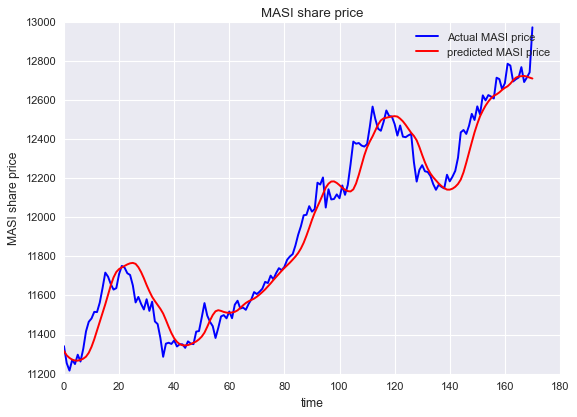

In [98]:
import matplotlib.style as style
style.use('seaborn')
plt.plot(actual_prices, color='blue', label=f"Actual MASI price")
plt.plot(predicted_prices, color= 'red', label=f"predicted MASI price")
plt.title(f"MASI share price")
plt.xlabel("time")
plt.ylabel(f"MASI share price")
plt.legend()
plt.show()

## Conclusion
Il est impossible d'obtenir un modèle qui puisse prédire le prix à 99% sans aucune erreur, il y a trop de facteurs qui peuvent affecter les prix des actions. Nous ne pouvons donc pas espérer qu'il existe un modèle parfait, mais la tendance générale du prix prédit est conforme aux données réelles.
En outre, nous pouvons améliorer la précision du modèle en augmentant "Epoch" ou en essayant différentes fonctions d'activation.
